In [1]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [10, 8]
import scipy
import scipy.integrate

pi = np.pi

# Since we're using a weird way to calculate the variance, need to define a new variance function
def getVariance(x, mu):
    ''' 
    x is the measurement, mu is the mean/'correct' value
    (x & mu are assumed to be the same length)
    returns total variance
    '''
    if (len(x) != len(mu)):
        print("*** NOTE: VARIANCE CALCULATED WITH DIFFERENT LENGTH VECTORS ***")
        print("Len of x:", len(x), "; len of mu:", len(mu))
    
    return ( np.sum( (x-mu)**2 )/(len(mu) - 1) )

# create file names and open file data
runNumber = '1'
carNumber = '3'

viconFileName = 'VICON_Data-Run_' + runNumber + '-Car_Number_' + carNumber + '.txt'
sensorFileName = 'Sensor_Data-Run_' + runNumber + '-Car_Number_' + carNumber + '.txt'
waypointFileName = 'Waypoint_Data-Run_' + runNumber + '-Car_Number_' + carNumber +'.txt'

viconData = np.genfromtxt(viconFileName, skip_header=1)
sensorData = np.genfromtxt(sensorFileName, skip_header=1)
waypointData = np.genfromtxt(waypointFileName, skip_header=1)

In [2]:
# Take data and divide it into pieces
# Vicon data
viconT = viconData[:,0]
viconX = viconData[:,1]
viconY = viconData[:,2]
viconTheta = viconData[:,3]
viconTheta_dot = viconData[:,4]
viconSpeed = viconData[:,5]

# The x, y, & z axes are probably weirdly aligned with the vicon x & y so thats why there's a weird name here
# Sensor Data
sensorT = sensorData[:,0]
sensorVHead = sensorData[:,1]
sensorAxs = sensorData[:,2]
sensorAys = sensorData[:,3]
sensorAzs = sensorData[:,4]
sensorMxs = sensorData[:,5]
sensorMys = sensorData[:,6]
sensorMzs = sensorData[:,7]
sensorGxs = sensorData[:,8]
sensorGys = sensorData[:,9]
sensorGzs = sensorData[:,10]

# Waypoint (Desired) Data
waypointT = waypointData[:,0] # NOTE: THIS IS JUST THE TIME THE POINT WAS EVALUATED
waypointX = waypointData[:,1]
waypointY = waypointData[:,2]
waypointVhead = waypointData[:,3]
waypointVlat = waypointData[:,4]
waypointTheta = waypointData[:,5]
waypointTheta_dot = waypointData[:,6]

# Move the starting times to 0
viconT = viconT - viconT[0]
sensorT = sensorT - sensorT[0]
waypointT = waypointT - waypointT[0]

In [3]:
# Trim out the bad data
viconX = viconX[viconT > 200]
viconY = viconY[viconT > 200]
viconTheta = viconTheta[viconT > 200]
viconTheta_dot = viconTheta_dot[viconT > 200]
viconSpeed = viconSpeed[viconT > 200]
viconT = viconT[viconT > 200]

sensorVHead = sensorVHead[sensorT > 200]
sensorAxs = sensorAxs[sensorT > 200]
sensorAys = sensorAys[sensorT > 200]
sensorAzs = sensorAzs[sensorT > 200]
sensorMxs = sensorMxs[sensorT > 200]
sensorMys = sensorMys[sensorT > 200]
sensorMzs = sensorMzs[sensorT > 200]
sensorGxs = sensorGxs[sensorT > 200]
sensorGys = sensorGys[sensorT > 200]
sensorGzs = sensorGzs[sensorT > 200]
sensorT = sensorT[sensorT > 200]

waypointX = waypointX[waypointT > 200]
waypointY = waypointY[waypointT > 200]
waypointVhead = waypointVhead[waypointT > 200]
waypointVlat = waypointVlat[waypointT > 200]
waypointTheta = waypointTheta[waypointT > 200]
waypointTheta_dot = waypointTheta_dot[waypointT > 200]
waypointT = waypointT[waypointT > 200]

# Sensor data unit conversion factors (time doesn't get scaled)
kVHead = 1.0
kAccel = 9.81/16384   # puts acceleration in m/s^2
kMag = 1.0
kGyro = (pi/2)/10285   # puts gyro (ang vel) in rad/s

# Update sensor data to the right units
sensorVHead *= kVHead
sensorAxs *= kAccel
sensorAys *= kAccel
sensorAzs *= kAccel
sensorMxs *= kMag
sensorMys *= kMag
sensorMzs *= kMag
sensorGxs *= kGyro
sensorGys *= kGyro
sensorGzs *= kGyro

''' The important X is X = [ x, y, v^H, v^L, theta, theta_dot ] and we are not paying attention to the measurements of x & y ''';

# Edit waypoint theta_dot because it has a delta function in it


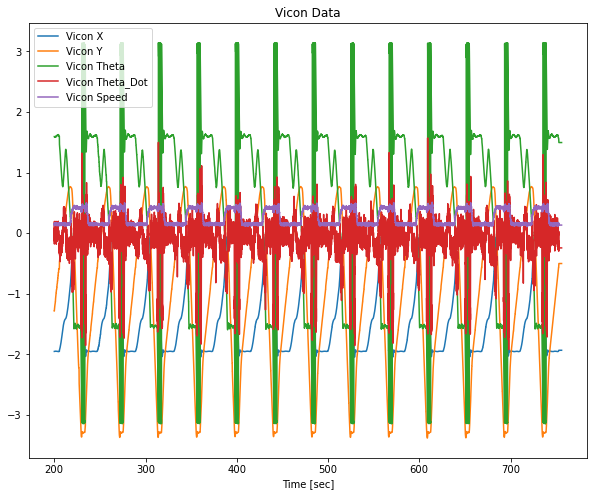

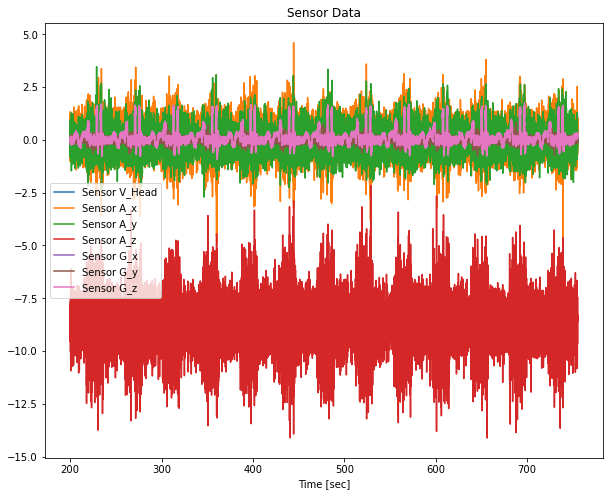

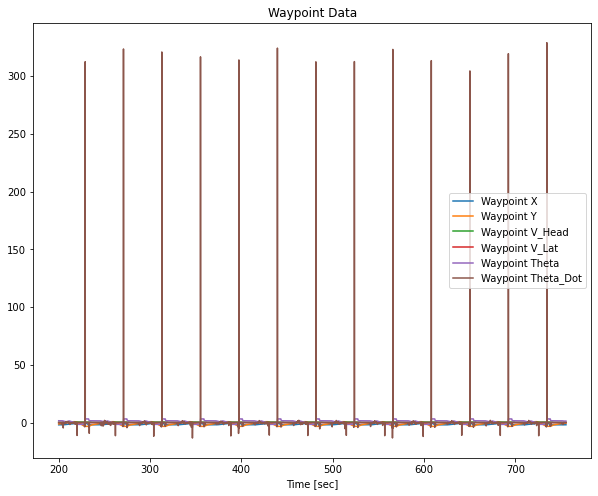

In [4]:
# Plot data to see what's necessary
# Vicon Data
plt.plot(viconT, viconX, label = 'Vicon X')
plt.plot(viconT, viconY, label = 'Vicon Y')
plt.plot(viconT, viconTheta, label = 'Vicon Theta')
plt.plot(viconT, viconTheta_dot, label = 'Vicon Theta_Dot')
plt.plot(viconT, viconSpeed, label = 'Vicon Speed')
plt.xlabel('Time [sec]'); plt.title('Vicon Data'); plt.legend(); plt.figure();

# Sensor Data
plt.plot(sensorT, sensorVHead, label = 'Sensor V_Head') # This is the only non-constant signal
plt.plot(sensorT, sensorAxs, label = 'Sensor A_x')
plt.plot(sensorT, sensorAys, label = 'Sensor A_y')
plt.plot(sensorT, sensorAzs, label = 'Sensor A_z')
plt.plot(sensorT, sensorGxs, label = 'Sensor G_x')
plt.plot(sensorT, sensorGys, label = 'Sensor G_y')
plt.plot(sensorT, sensorGzs, label = 'Sensor G_z')
#plt.plot(sensorT, sensorMxs, label = 'Sensor M_x')
#plt.plot(sensorT, sensorMys, label = 'Sensor M_y')
#plt.plot(sensorT, sensorMzs, label = 'Sensor M_z')
plt.xlabel('Time [sec]'); plt.title('Sensor Data'); plt.legend(); plt.figure();

# Waypoint Data
plt.plot(waypointT, waypointX, label = 'Waypoint X')
plt.plot(waypointT, waypointY, label = 'Waypoint Y')
plt.plot(waypointT, waypointVhead, label = 'Waypoint V_Head')
plt.plot(waypointT, waypointVlat, label = 'Waypoint V_Lat')
plt.plot(waypointT, waypointTheta, label = 'Waypoint Theta')
plt.plot(waypointT, waypointTheta_dot, label = 'Waypoint Theta_Dot')
plt.xlabel('Time [sec]'); plt.title('Waypoint Data'); plt.legend();

In [5]:
# remove all unnecessary variables to save memory
del viconData, sensorData, waypointData # the full tables of data
# Figure out which A's, M's, and G's we need to keep and delete the others

<Figure size 720x576 with 0 Axes>

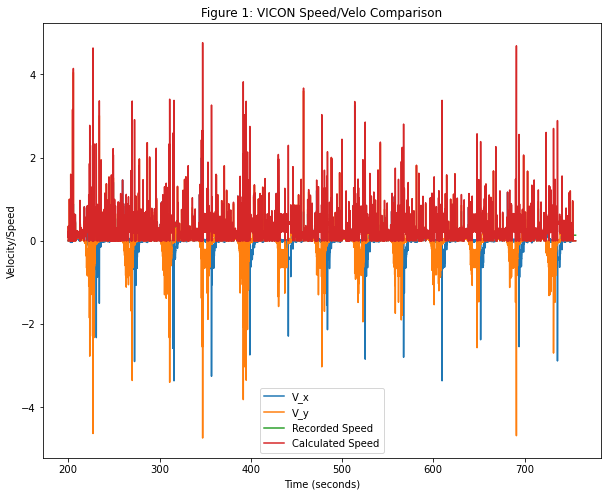

<Figure size 720x576 with 0 Axes>

In [6]:
# Calculate the x and y velocities from VICON
viconVx = np.zeros_like(viconT[:-1])
viconVy = np.zeros_like(viconT[:-1])

viconDeltaX = viconX[1:] - viconX[:-1]
viconDeltaY = viconY[1:] - viconY[:-1]
viconDeltaT = viconT[1:] - viconT[:-1]

for i in range(len(viconVx)):
    viconVx[i] = viconDeltaX[i]/viconDeltaT[i]
    viconVy[i] = viconDeltaY[i]/viconDeltaT[i]

# Calc Heading Velocity
viconHeadingVector = np.array([np.cos(viconTheta), np.sin(viconTheta)])
viconHeadingVector = viconHeadingVector.transpose()
viconVeloVector = np.array([viconVx, viconVy])
viconVHead = np.dot(viconHeadingVector[:-1], viconVeloVector)
  
# For a sanity check plot against the recorded speed graph
plt.plot(viconT[:-1], viconVx, label = 'V_x')
plt.plot(viconT[:-1], viconVy, label = 'V_y')
plt.plot(viconT, np.abs(viconSpeed), label = 'Recorded Speed')
plt.plot(viconT[:-1], np.sqrt(viconVx**2 + viconVy**2), label = 'Calculated Speed')
plt.xlabel('Time (seconds)'); plt.ylabel('Velocity/Speed'); plt.title('Figure 1: VICON Speed/Velo Comparison')
plt.legend(); plt.figure()

<Figure size 720x576 with 0 Axes>

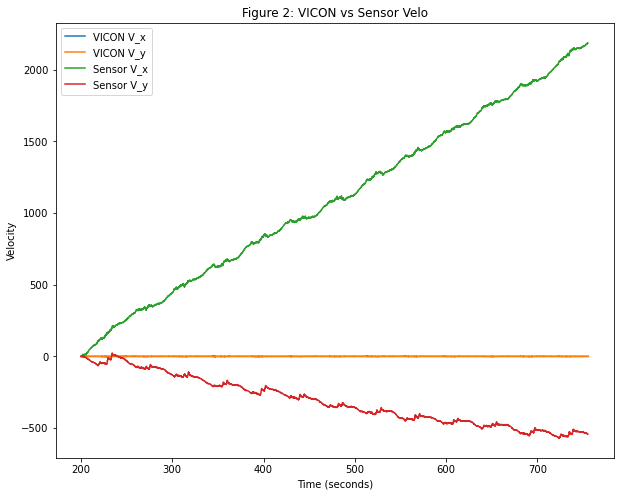

<Figure size 720x576 with 0 Axes>

In [7]:
# initialize the sensor acceleration velocity vectors
sensorVxs = np.zeros_like(sensorT[:-1])
sensorVys = np.zeros_like(sensorT[:-1])
sensorVzs = np.zeros_like(sensorT[:-1])

# integrate the acceleration data cumulatively to find the velocity in each direction
sensorVxs = scipy.integrate.cumtrapz(sensorAxs)
sensorVys = scipy.integrate.cumtrapz(sensorAys)
sensorVzs = scipy.integrate.cumtrapz(sensorAzs) #should (hopefully) stay around zero and be ignored eventually

# plot to compare velo's
plt.plot(viconT[:-1], viconVx, label = 'VICON V_x')
plt.plot(viconT[:-1], viconVy, label = 'VICON V_y')
plt.plot(sensorT[:-1], sensorVxs, label = 'Sensor V_x')
plt.plot(sensorT[:-1], sensorVys, label = 'Sensor V_y')
# plt.plot(sensorT[:-1], sensorVzs, label = 'Sensor V_z')
plt.xlabel('Time (seconds)'); plt.ylabel('Velocity'); plt.title('Figure 2: VICON vs Sensor Velo')
plt.legend(); plt.figure()

In [8]:
'''# plot to compare speeds
plt.plot(viconT, viconSpeed, label = 'VICON Speed')
plt.plot(viconT[:-1], np.sqrt(viconVx**2 + viconVy**2), label = 'VICON Calculated Speed')
plt.plot(viconT[:-1], viconVHead, label = 'VICON Heading Velocity')
plt.plot(sensorT[:-1], np.sqrt(sensorVxs**2 + sensorVys**2 + sensorVzs**2), label = 'Sensor Calculated Speed')
plt.plot(sensorT, sensorVHead, label = 'Encoder Speed')
plt.xlabel('Time (seconds)'); plt.ylabel('Speed'); plt.title('Figure 3: VICON vs Sensor Speed & Heading Velo')
plt.legend(); plt.figure()''';

In [9]:
# TODO - FIGURE OUT IF THE ACCELERATIONS OUTPUT INTRINSICALLY OR EXTRINSICALLY

# Initialize variance variables
varVHead = 0.0
varVLat = 0.0
varTheta = 0.0
varTheta_dot = 0.0

In [10]:
# calculate variances




# Fin

220.1600000858307
209.6100001335144
480


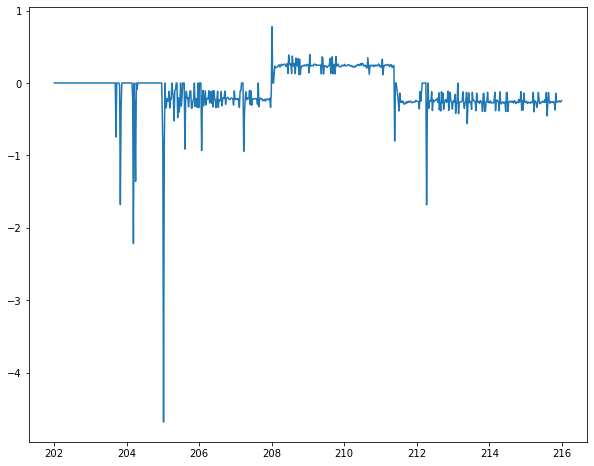

In [11]:
plt.plot(waypointT[100:800], waypointTheta_dot[100:800]);
print(waypointT[np.abs(waypointTheta_dot) > 10][0])
i = 0
while (waypointT[i] < 209.59):
    i += 1;
print(waypointT[i]); print(i)

In [12]:
print(waypointT[i-1])
print(waypointTheta[i-1])
print(waypointTheta[i])
d = ( waypointTheta[i] - waypointTheta[i-1] )/( waypointT[i] - waypointT[i-1] )
print(d)
print(waypointTheta_dot[i])
# Okay so this is odd what do I do with the delta functions?
# if over 2pi then replace with ΔΘ/Δt (calculated)

209.5899999141693
1.01681186883
1.02424540023
0.3716724937731199
0.338123756745
